In [6]:
from torchvision import transforms
import torch
import torch.nn as nn
import numpy as np
from matplotlib import image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from nn_modules import Conv_ATM, Encoder

This is used for creating the final image based on the turkish satellite image

In [7]:
#see training.py for explaination
crop_size = 128
n_samples = 250
depths=[3, 3, 3, 9, 3]
dims=[3, 6, 12, 24, 48]
patch_size=16
dConv_kernel_size = 5
name = 'Transformer classifier'
device = 'cuda'

ckpt = 'ATM_ViT_ckpt2_12.pt'

encoder = Encoder(depths=depths,dims = dims, dConv_kernel_size = dConv_kernel_size)
model = Conv_ATM(encoder=encoder,dim=dims[-1]).to(device)

model.load_state_dict(torch.load(ckpt))

<All keys matched successfully>

In [9]:
#reading the image of islahiye turkey
islahiye = image.imread('./TurkeySatellite/1040010082698700-visual(3).png')[:,:,:3]
#make a cropping, this isn't necesarry but we didn't want the full image
n_tiles = np.divide(islahiye[:,:12288].shape[:2],128).astype(int)

#splitting the image into tiles
tiles = []
for c_i in range(n_tiles[1]):
    for r_i in range(n_tiles[0]):
        tile = islahiye[:,:12288][r_i*128:(r_i+1)*128,c_i*128:(c_i+1)*128,:]
        tiles.append(tile)

In [11]:
#normalization of the image
transform_norm = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[.5,.5,.5], std =[.5,.5,.5])])
#Reshape the list of tiles into the proper layout for the model tiles become items in the batch
data = torch.stack([transform_norm(tile).permute(1,2,0) for tile in tiles],dim=0)
#add to the dataloader
dataloader = DataLoader(data,batch_size=256,shuffle=False)
pbar = tqdm(dataloader)

  0%|          | 0/51 [00:00<?, ?it/s]

In [15]:
#see training.py for explaination its just missing the backpropagation and such otherwise its the same as the training loop in Conv_ATM
segments = []
for i, samples in enumerate(pbar):
    num_patches = samples.shape[1]//patch_size
    samples = samples.to(device)
    background = torch.ones((samples.shape[0],1,crop_size,crop_size)).to(device)

    q, attns, class_prediction = model(samples.to(device))

    fold = nn.Fold((num_patches,num_patches),kernel_size=1)
    out_masks = []
    for i, attn in enumerate(attns):
        if i == 0:
            out_masks.append(nn.functional.interpolate(fold(attn),size=(128,128), mode = 'bilinear',align_corners=False))
        else:
            out_masks.append(out_masks[i-1]+
                                nn.functional.interpolate(fold(attn),size=(128,128), mode = 'bilinear',align_corners=False)) 
    out_masks = out_masks[-1]

    mask_with_background = torch.concat([out_masks,background],dim=1)

    semseg = torch.einsum('bcq,bqhw->bqhw', class_prediction,mask_with_background).softmax(dim=1)
    segments.extend(semseg.permute(0,2,3,1).cpu().detach().numpy())

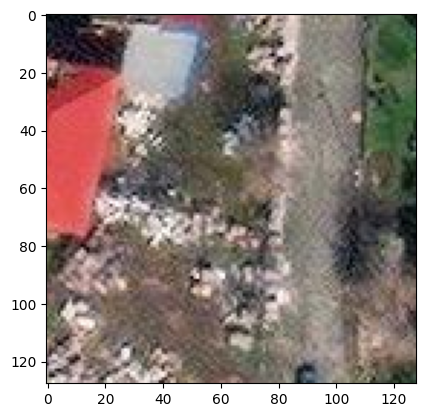

In [22]:
plt.imshow(tiles[11300])

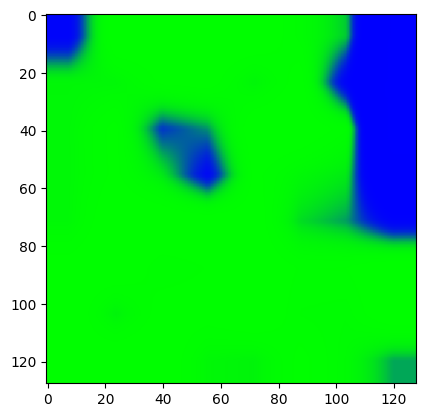

In [23]:
plt.imshow(segments[11300])

In [31]:
n_tiles = np.divide(islahiye[:,:12288].shape[:2],128).astype(int)
output = np.zeros_like(islahiye[:,:12288])
tiles = []
i = 0
#putting the image tiles back together to form the output image
for c_i in range(n_tiles[1]):
    for r_i in range(n_tiles[0]):
        output[r_i*128:(r_i+1)*128,c_i*128:(c_i+1)*128,:] = segments[i]
        i+=1

In [35]:
plt.imsave('output.png',output)